# Intel Image Classification

This Data contains around 25k images of size 150x150 distributed under 6 categories. 

{'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. 

There are around 14k images in Train, 3k in Test and 7k in Prediction. 

## Download the data
https://www.kaggle.com/puneet6060/intel-image-classification

## Parameters

In [1]:
train_file_path = 'data/seg_train'
val_file_path = 'data/seg_test'
test_file_path = 'data/seg_pred'

labels_to_int = {'buildings' : 0, 'forest' : 1, 'glacier' : 2, 'mountain': 3, 'sea' : 4, 'street' : 5 }
int_to_labels = { 0 : 'buildings' , 1 : 'forest' , 2 : 'glacier', 3 : 'mountain', 4 : 'sea' ,  5 : 'street'}

number_of_epochs = 20
validation_split = 0.3
batch_size = 64

# re-size all the images to this
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
IMAGE_CHANNELS = 3

# Load Dataset

In [2]:
import os
import cv2
from sklearn.utils import shuffle
from numpy import array

def load_data(dir):
    images = []
    labels = []    
    for label in  os.listdir(dir):
        int_label = labels_to_int[label]        
        for image_file_path in os.listdir(dir + '/'+label):            
            image = cv2.imread(dir + '/'+ label + '/'+ image_file_path)
            image = cv2.resize(image,(IMAGE_WIDTH,IMAGE_HEIGHT))
            image = image/255
            images.append(image)
            labels.append(int_label)
    images = array(images)
    labels = array(labels)
    return shuffle(images,labels,random_state=0)

train_images, train_labels = load_data(train_file_path)
val_images, val_labels = load_data(val_file_path)

In [3]:
print ("train_images shape : " + str(train_images.shape))
print ("train_labels shape : " + str(train_labels.shape))
print ("val_images shape : " + str(val_images.shape))
print ("val_labels shape : " + str(val_labels.shape))

train_images shape : (14034, 150, 150, 3)
train_labels shape : (14034,)
val_images shape : (3000, 150, 150, 3)
val_labels shape : (3000,)


In [4]:
from keras.utils.np_utils import to_categorical 
train_x = train_images
train_y = to_categorical(train_labels, num_classes=len(labels_to_int))

val_x = val_images
val_y = to_categorical(val_labels, num_classes=len(labels_to_int))

Using TensorFlow backend.


## Display Some images

In [5]:
import matplotlib.pyplot as plt
def show_image(img):
    img = img
    plt.imshow(img)
    plt.gray()
    plt.show()
import random
for i in range(2):
    pos = random.randint(0,train_images.shape[0])
    show_image(train_images[pos])
    print(int_to_labels[train_labels[pos]])

<Figure size 640x480 with 1 Axes>

forest


<Figure size 640x480 with 1 Axes>

forest


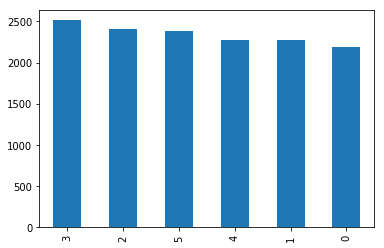

In [6]:
import pandas as pd
pd_train_labels = pd.DataFrame({'labels': train_labels[:]})
pd.value_counts(pd_train_labels['labels']).plot.bar()

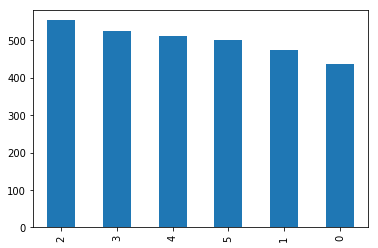

In [7]:
pd_val_labels = pd.DataFrame({'labels': val_labels[:]})
pd.value_counts(pd_val_labels['labels']).plot.bar()

# Build Models 

In [8]:
def plot_accuracy(history):    

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
def plot_loss(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

## Model 1 - Artificial Neural Network

In [10]:
def get_model1():
    model = Sequential()    
    model.add(Flatten(input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))    
    model.add(Dense(1024, activation = "relu"))    
    model.add(Dropout(0.1))    
    model.add(Dense(512, activation = "relu"))    
    model.add(Dropout(0.1))   
    model.add(Dense(512, activation = "relu"))    
    model.add(Dropout(0.1))  
    model.add(Dense(128, activation = "relu"))    
    model.add(Dropout(0.1))  
    model.add(Dense( len(labels_to_int), activation = "softmax"))    
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)    
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])    
    return model

In [11]:
model1 = get_model1()
model1.summary()
history = model1.fit(x=train_x, y=train_y, batch_size=64, epochs=15, validation_data=(val_x, val_y) )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              69121024  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)      

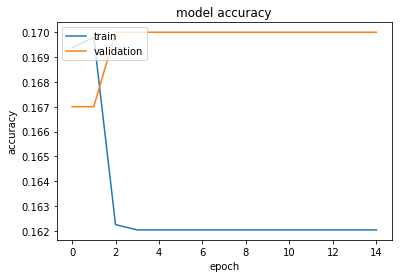

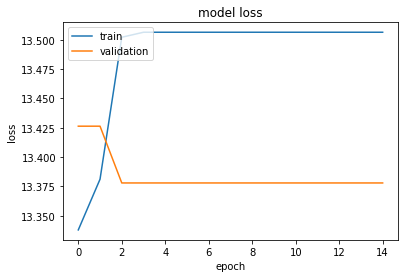

In [12]:
plot_accuracy(history)
plot_loss(history)

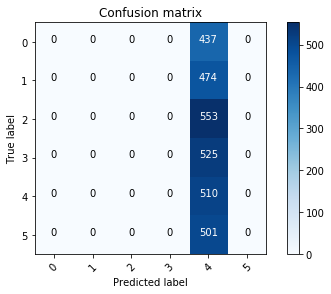

In [13]:
true = val_labels
pred = model1.predict_classes(val_x)
confusion_mtx = confusion_matrix(true, pred) 
plot_confusion_matrix(confusion_mtx, classes = range(len(labels_to_int))) 

## Model2 - Convolutional Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
__________

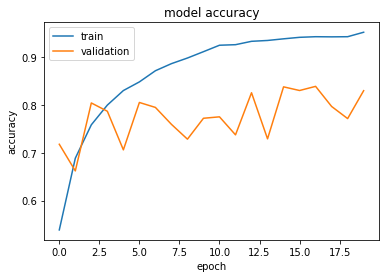

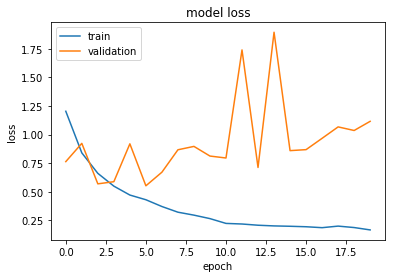

In [14]:
def get_model2():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(3,3)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(3,3)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    
    model.add(Dense(256, activation = "relu"))    
    model.add(Dropout(0.2))
    
    model.add(Dense(len(labels_to_int), activation = "softmax"))
    
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)    
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) 
    
    return model

model2 = get_model2()
model2.summary()
history2 = model2.fit(x=train_x, y=train_y, batch_size=64, epochs=20, validation_data=(val_x, val_y) )
plot_accuracy(history2)
plot_loss(history2)

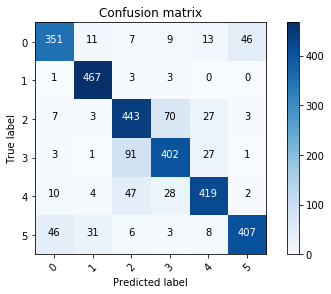

In [15]:
true = val_labels
pred = model2.predict_classes(val_x)
confusion_mtx = confusion_matrix(true, pred) 
plot_confusion_matrix(confusion_mtx, classes = range(len(labels_to_int))) 

## Model 3 - Bigger Convolutional Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 180)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 23, 23, 100)       126100    
__________

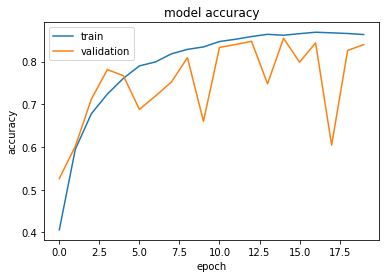

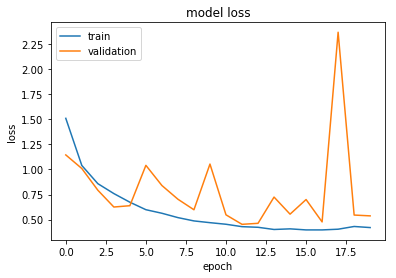

In [16]:
def get_model3():
    
    model = Sequential()

    model.add(Conv2D(filters = 200, kernel_size = (3,3),
                     activation ='relu', input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
    model.add(Conv2D(filters = 180, kernel_size = (3,3), activation ='relu'))
    model.add(MaxPool2D(pool_size=(5,5)))
    model.add(Dropout(0.2))


    model.add(Conv2D(filters = 180, kernel_size = (3,3),  activation ='relu'))
    model.add(Conv2D(filters = 140, kernel_size = (3,3),  activation ='relu'))
    model.add(Conv2D(filters = 100, kernel_size = (3,3),  activation ='relu'))
    model.add(Conv2D(filters = 50, kernel_size = (3,3),  activation ='relu'))
    model.add(MaxPool2D(pool_size=(5,5)))
    model.add(Dropout(0.2))


    model.add(Flatten())
    
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation = "relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(len(labels_to_int), activation = "softmax"))
    
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)    
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) 

#     optimizer=Adam(lr=0.0001)
#     model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

model3= get_model3()
model3.summary()
history3 = model3.fit(x=train_x, y=train_y, batch_size=64, epochs=20, validation_data=(val_x, val_y) )
plot_accuracy(history3)
plot_loss(history3)

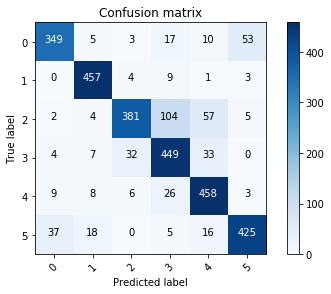

In [17]:
true = val_labels
pred = model3.predict_classes(val_x)
confusion_mtx = confusion_matrix(true, pred) 
plot_confusion_matrix(confusion_mtx, classes = range(len(labels_to_int))) 

# Model 4 : Pretrained VGG16

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

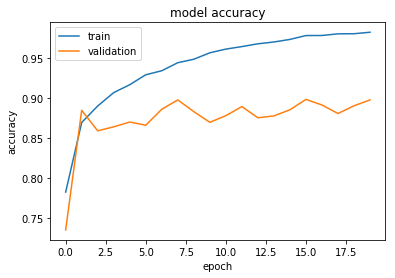

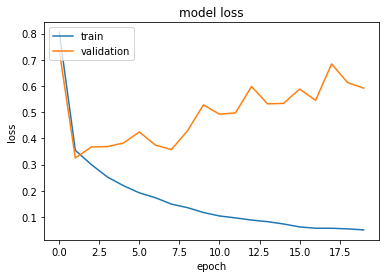

In [18]:
def get_model4():
    
    vgg = VGG16(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS), weights='imagenet', include_top=False)
    for layer in vgg.layers:
      layer.trainable = False    
    
    x = Flatten()(vgg.output)

    x = Dense(512, activation = "relu")(x)
    x = (Dropout(0.2))(x)    
    
    x = Dense(len(labels_to_int), activation = "softmax")(x)
    
    model = Model(inputs=vgg.input, outputs=x)
    
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)    
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) 
    
    return model
    
model4= get_model4()
model4.summary()
history4 = model4.fit(x=train_x, y=train_y, batch_size=64, epochs=20, validation_data=(val_x, val_y) )
plot_accuracy(history4)
plot_loss(history4)

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

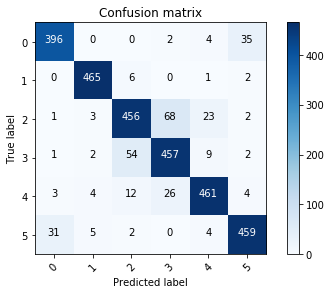

In [19]:
true = val_labels
pred  = model4.predict(val_x)
pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(true, pred) 
plot_confusion_matrix(confusion_mtx, classes = range(len(labels_to_int))) 
int_to_labels

# Model 5 : Pretrained InceptionV3

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_12 

14034/14034 [==============================] - 19s 1ms/step - loss: 3.8328 - acc: 0.5617 - val_loss: 0.8992 - val_acc: 0.7920
Epoch 2/20
14034/14034 [==============================] - 16s 1ms/step - loss: 0.7508 - acc: 0.7617 - val_loss: 0.8566 - val_acc: 0.7730
Epoch 3/20
14034/14034 [==============================] - 16s 1ms/step - loss: 0.6061 - acc: 0.8031 - val_loss: 0.7716 - val_acc: 0.8133
Epoch 4/20
14034/14034 [==============================] - 16s 1ms/step - loss: 0.5446 - acc: 0.8182 - val_loss: 0.8942 - val_acc: 0.7850
Epoch 5/20
14034/14034 [==============================] - 16s 1ms/step - loss: 0.4931 - acc: 0.8382 - val_loss: 0.8755 - val_acc: 0.8097
Epoch 6/20
14034/14034 [==============================] - 15s 1ms/step - loss: 0.4456 - acc: 0.8580 - val_loss: 0.8344 - val_acc: 0.8343
Epoch 7/20
14034/14034 [==============================] - 16s 1ms/step - loss: 0.3917 - acc: 0.8734 - val_loss: 0.9941 - val_acc: 0.7963
Epoch 8/20
14034/14034 [============================

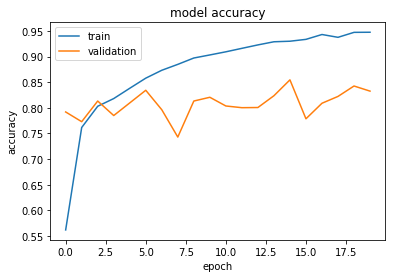

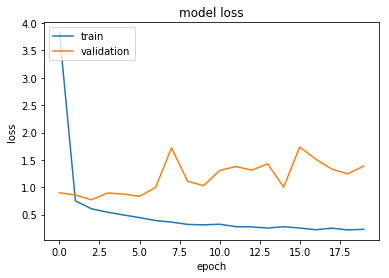

In [20]:
def get_model5():
    inception = InceptionV3(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS), weights='imagenet', include_top=False)
    
    for layer in inception.layers:
      layer.trainable = False    
    
    x = Flatten()(inception.output)

    x = Dense(512, activation = "relu")(x)
    x = (Dropout(0.2))(x)    
    
    x = Dense(len(labels_to_int), activation = "softmax")(x)
    
    model = Model(inputs=inception.input, outputs=x)
    
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)    
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) 
    
    return model

model5= get_model5()
model5.summary()
history5 = model5.fit(x=train_x, y=train_y, batch_size=64, epochs=20, validation_data=(val_x, val_y) )
plot_accuracy(history5)
plot_loss(history5)

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

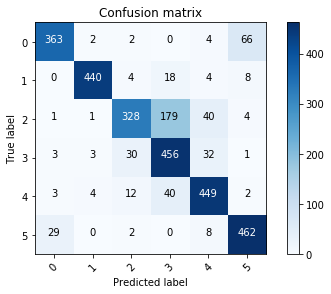

In [21]:
true = val_labels
pred  = model5.predict(val_x)
pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(true, pred) 
plot_confusion_matrix(confusion_mtx, classes = range(len(labels_to_int))) 
int_to_labels

# Test On new Images

In [22]:
# Load Test Images
test_images = []
for image_file_path in os.listdir(test_file_path ):            
    image = cv2.imread(test_file_path + '/'+ image_file_path)
    image = cv2.resize(image,(IMAGE_WIDTH,IMAGE_HEIGHT))
    image = image/255
    test_images.append(image)
test_images = array(test_images)
print(test_images.shape)

(7301, 150, 150, 3)


In [23]:
pred  = model5.predict(test_images)
pred = np.argmax(pred, axis=1)

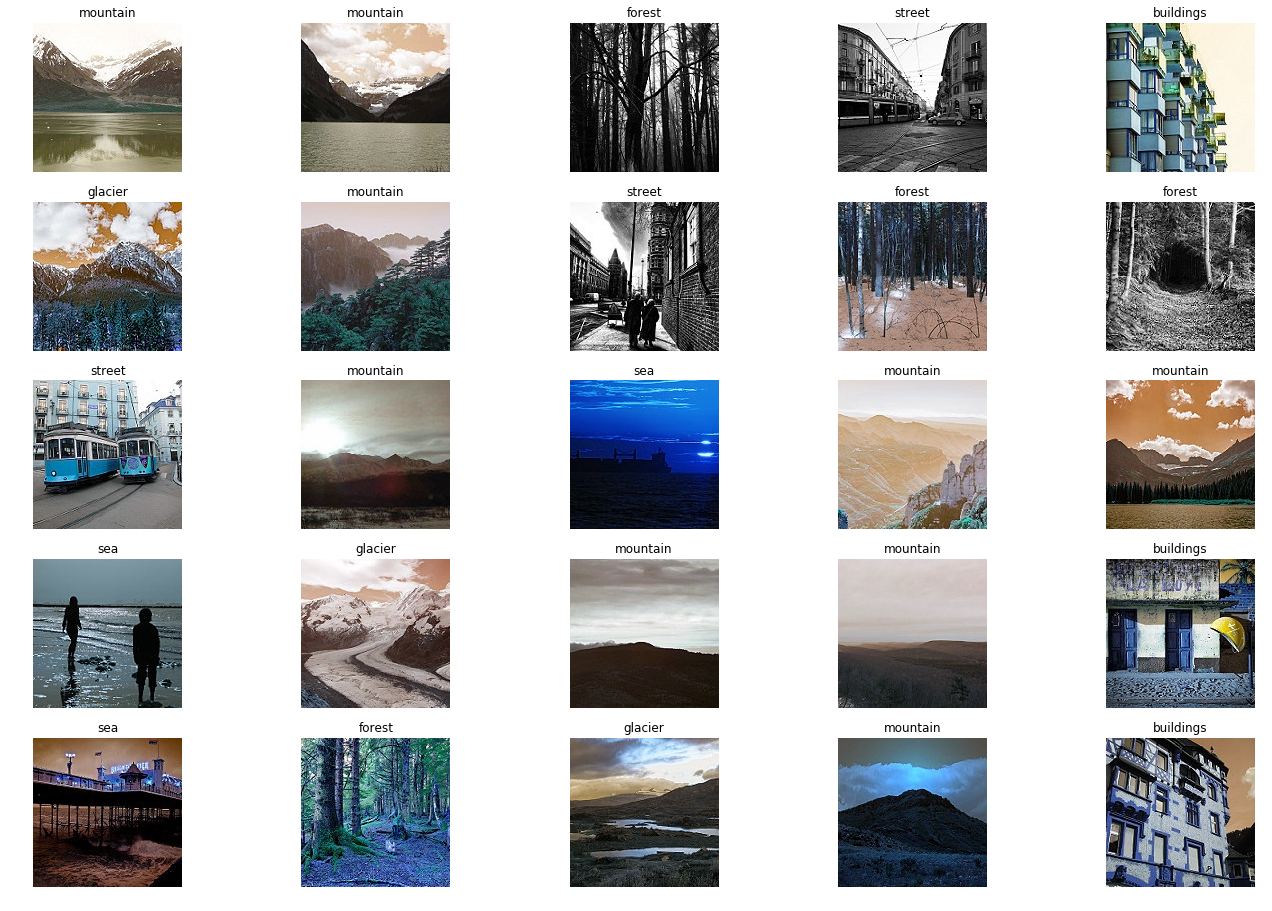

In [24]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = random.randint(0,len(test_images))
        ax[i,j].imshow(test_images[rnd_number])
        ax[i,j].set_title(int_to_labels[pred[rnd_number]])
        ax[i,j].axis('off')